# Classification et K-means

In [1]:
# chargement des données
import pandas as pd

# coordonnées factorielles des villes
rowcoord = pd.read_pickle('temperature.pkl')
# données brutes
actif = pd.read_excel('temperature.xlsx',sheet_name=0,header=0,index_col=0)
sup = pd.read_excel('temperature.xlsx',sheet_name=1,header=0,index_col=0)
donnee = pd.concat([actif,sup],axis=1)
# Dimension
(n,p) = rowcoord.shape

## Classification

### Matrice de liens

In [2]:
# Matrice des liens
import numpy as np
from scipy.cluster.hierarchy import linkage

matrix = linkage(rowcoord,"ward")
linkmat = pd.DataFrame(matrix,index = np.arange(1,n,1),
                       columns = ["Ind 1", "Ind 2","Distance", "Poids"])
display(linkmat)

,Ind 1,Ind 2,Distance,Poids
1,2.0,14.0,0.540535,2.0
2,6.0,7.0,0.859403,2.0
3,3.0,5.0,0.877949,2.0
4,10.0,15.0,1.192691,3.0
5,8.0,11.0,1.307175,2.0
6,0.0,13.0,1.637345,2.0
7,17.0,18.0,2.230769,5.0
8,9.0,16.0,2.435392,3.0
9,4.0,12.0,2.820679,2.0
10,1.0,19.0,3.552803,3.0


In [3]:
# Méthode ward
from scipy.cluster.hierarchy import ward

wardmatrix = ward(rowcoord)

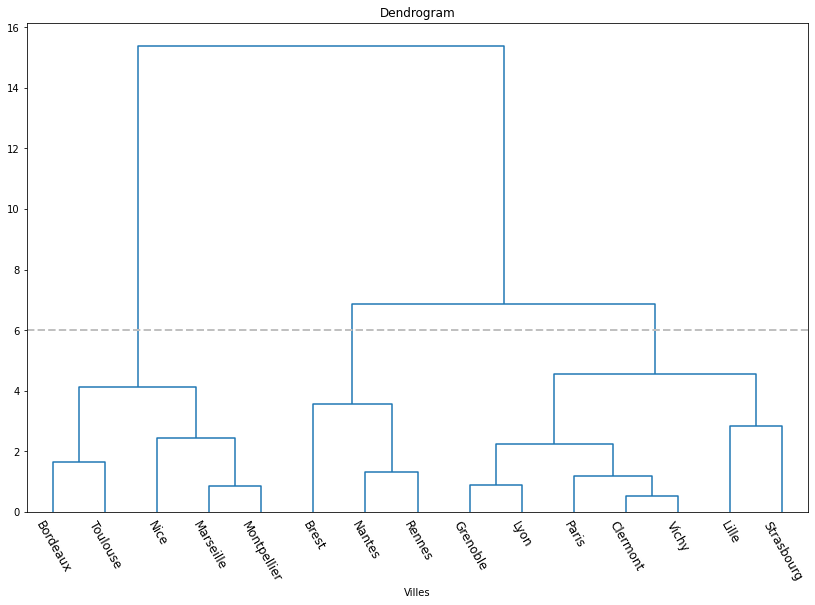

In [4]:
# Dendrogramme
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize = (14,9))
dendrogram(linkmat,labels = rowcoord.index, orientation = "top",
           color_threshold = 0)
plt.plot([0,150], [6,6], color = "silver", linestyle = "--", linewidth = 2)
plt.title("Dendrogram")
plt.xlabel('Villes')
plt.tick_params(axis = "x", rotation = -60)
plt.show()

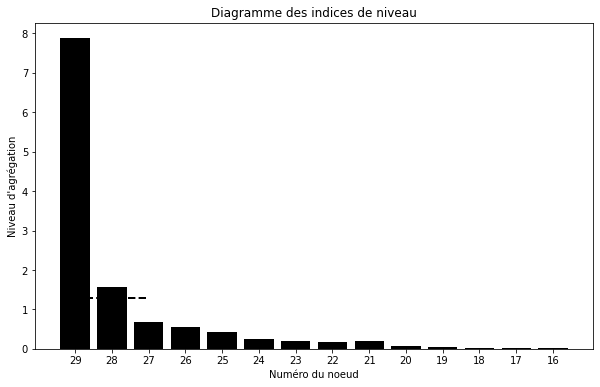

In [5]:
# Barplot
import seaborn as sns
# Inertie perdue
inertiePerdue =np.array([7.88, 1.56, 0.69, 0.56,0.42, 0.26, 0.19,
                         0.17, 0.19, 0.06, 0.05, 0.03, 0.02, 0.01])

fig2, axis = plt.subplots(figsize = (10,6))
sns.barplot(x = np.arange(1,n,1), y = inertiePerdue,
           color = "black")
plt.plot([0,2], [1.3,1.3], color = "black", linestyle = "--", linewidth = 2)
axis.set_xticklabels([str(i) for i in np.arange(29,15,-1)])
axis.set_title("Diagramme des indices de niveau")
axis.set_xlabel("Numéro du noeud")
axis.set_ylabel("Niveau d'agrégation")
plt.show()

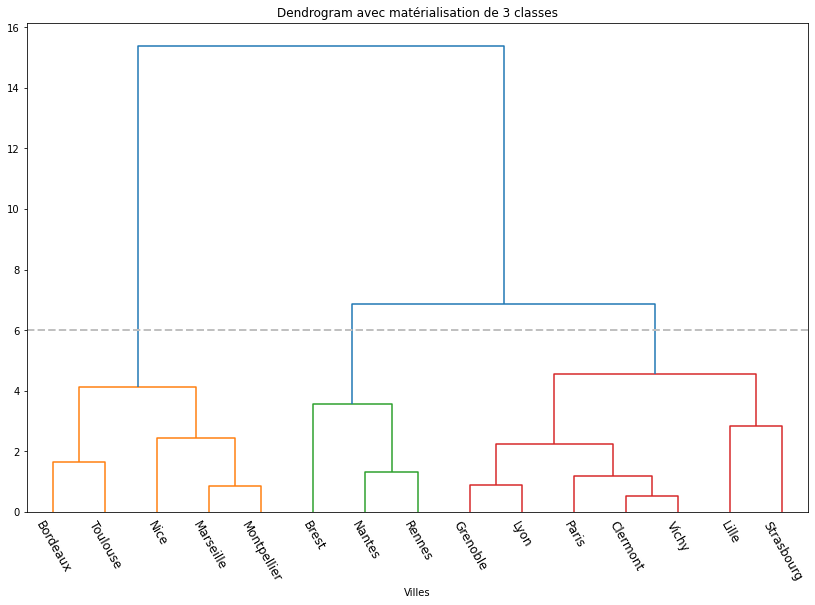

In [6]:
# Arbre avec 3 classes
nivCoup=6
plt.figure(figsize = (14,9))
dendrogram(linkmat, labels = donnee.index, distance_sort = "ward",
           orientation = "top", color_threshold = nivCoup)
plt.plot([0,150], [nivCoup,nivCoup], color = "silver", linestyle = "--", 
         linewidth = 2)
plt.title("Dendrogram avec matérialisation de 3 classes")
plt.xlabel('Villes')
plt.tick_params(axis = "x", rotation = -60)
plt.show()

In [7]:
# Découpage en 3 classes
from scipy.cluster.hierarchy import fcluster

cahGroupe = fcluster(linkmat, t = nivCoup, criterion = "distance")
classes = pd.DataFrame(cahGroupe, index = donnee.index,columns = ["classe"])
display(classes)

,classe
Villes,
Bordeaux,1
Brest,2
Clermont,3
Grenoble,3
Lille,3
Lyon,3
Marseille,1
Montpellier,1
Nantes,2


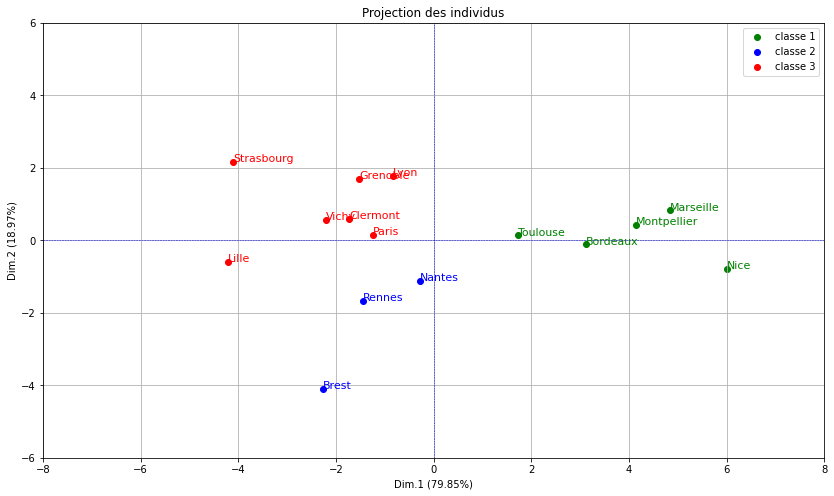

In [8]:
# Graphique
fig, axes = plt.subplots(figsize = (14,8)); axes.grid()
axes.axis([-8,8,-6,6])
axes.set_title("Projection des individus")
axes.set_xlabel("Dim.1 (79.85%)")
axes.set_ylabel("Dim.2 (18.97%)")
cdict = {'classe 1': 'green','classe 2': 'blue', 'classe 3':'red'}
for group in np.unique(classes.classe):
    idx = np.where(classes.classe==group)
    axes.scatter(rowcoord.iloc[:,0].values[idx[0]],rowcoord.iloc[:,1].values[idx[0]],
                 label = 'classe '+str(group), c = cdict['classe '+str(group)])
    for i in idx[0]:
        axes.text(rowcoord.iloc[:,0].values[i],rowcoord.iloc[:,1].values[i],
                  s=rowcoord.index[i],c =cdict['classe '+str(group)],fontsize = 11)
axes.legend()
plt.axhline(0, color='blue',linestyle="--", linewidth=0.5)
plt.axvline(0, color='blue',linestyle="--", linewidth=0.5)
plt.show()

In [9]:
# Regroupement
dico = dict()
for i in range(1,4,1):
    for j in classes.classe:
        if i==j:
            dico[f'classe {i}'] = list(classes[classes.classe==i].index)
# Affichage
for i, keys in enumerate(dico.keys()):
    print(f'classe {i+1} : {dico[keys]} : {len(dico[keys])} éléments')

classe 1 : ['Bordeaux', 'Marseille', 'Montpellier', 'Nice', 'Toulouse'] : 5 éléments
classe 2 : ['Brest', 'Nantes', 'Rennes'] : 3 éléments
classe 3 : ['Clermont', 'Grenoble', 'Lille', 'Lyon', 'Paris', 'Strasbourg', 'Vichy'] : 7 éléments


In [10]:
# Concaténation des données
df = pd.concat([donnee, classes], axis = 1)
# Effectifs par classes
nk = df.groupby(df.classe).size()
meanvar = donnee.mean(axis=0)        # moyenne générale
stdvar = donnee.std(axis=0,ddof=0)   # ecart-type général
# Moyennes conditionnelles
condmean = pd.pivot_table(df, values = donnee.columns,index=['classe'],
                          aggfunc=np.mean)[donnee.columns].T
# valeur-test
u = condmean.apply(lambda x : (x-meanvar)/stdvar, axis=0)
v = u.apply(lambda x : x*np.sqrt(nk*(n-1)/(n-nk)), axis=1)
v.columns = ['classe '+str(x+1) for x in range(len(dico))]
display(v.round(2))

,classe 1,classe 2,classe 3
Jan,2.46,1.28,-3.36
Fev,2.88,0.66,-3.25
Mars,3.24,-0.25,-2.85
Avril,3.33,-1.30,-2.11
Mai,3.00,-2.02,-1.22
Juin,3.00,-2.05,-1.19
Juil,2.92,-2.18,-1.00
Août,3.18,-2.02,-1.38
Sept,3.40,-1.45,-2.05
Oct,3.32,-0.41,-2.81


In [11]:
# Calcul des probabilités associées aux valeur-test
import scipy.stats as stats

prob = v.apply(lambda x : 2*(1-stats.norm(0,1).cdf(np.abs(x))))
display(prob.round(3))

,classe 1,classe 2,classe 3
Jan,0.014,0.201,0.001
Fev,0.004,0.512,0.001
Mars,0.001,0.800,0.004
Avril,0.001,0.195,0.035
Mai,0.003,0.044,0.224
Juin,0.003,0.040,0.233
Juil,0.004,0.029,0.315
Août,0.001,0.043,0.167
Sept,0.001,0.146,0.041
Oct,0.001,0.682,0.005


In [12]:
# ecart-types conditionnels
columns = ['V.test','Proba','classe','général','classe','général']
condstd = pd.pivot_table(df, values = donnee.columns,index=['classe'],
                          aggfunc=lambda x:np.std(x,ddof=0))[donnee.columns].T
# Caractéristiques de la classe 1
classe1 = pd.concat([v.iloc[:,0],prob.iloc[:,0],condmean.iloc[:,0],meanvar,
                     condstd.iloc[:,0],stdvar],axis=1)
classe1.columns = columns
display(classe1.sort_values(by='V.test',ascending=False).round(2))

,V.test,Proba,classe,général,classe,général
Sept,3.40,0.00,19.28,16.99,0.75,1.79
moy,3.39,0.00,13.80,11.81,0.74,1.55
Avril,3.33,0.00,12.70,10.98,0.58,1.37
Oct,3.32,0.00,14.54,12.32,0.94,1.77
Mars,3.24,0.00,10.04,8.23,0.52,1.48
Août,3.18,0.00,21.90,19.57,0.79,1.94
Juin,3.00,0.00,19.80,17.83,0.73,1.73
Mai,3.00,0.00,16.08,14.43,0.69,1.45
Nov,2.97,0.00,9.88,7.93,1.00,1.74
Juil,2.92,0.00,22.10,19.83,1.00,2.06


In [13]:
# Caractéristiques de la classe 2
classe2 = pd.concat([v.iloc[:,1],prob.iloc[:,1],condmean.iloc[:,1],meanvar,
                     condstd.iloc[:,1],stdvar],axis=1)
classe2.columns = columns
display(classe2.sort_values(by='V.test',ascending=False).round(2))

,V.test,Proba,classe,général,classe,général
Lati,1.49,0.14,47.81,46.04,0.48,2.22
Jan,1.28,0.20,5.30,3.97,0.57,1.94
Dec,1.11,0.27,5.97,4.85,0.73,1.89
Fev,0.66,0.51,5.47,4.83,0.24,1.81
Nov,0.44,0.66,8.33,7.93,0.50,1.74
Mars,-0.25,0.80,8.03,8.23,0.26,1.48
Oct,-0.41,0.68,11.93,12.32,0.25,1.77
moy,-0.75,0.46,11.20,11.81,0.38,1.55
Avril,-1.30,0.20,10.03,10.98,0.65,1.37
Sept,-1.45,0.15,15.60,16.99,0.70,1.79


In [14]:
# Caractéristiques de la classe 3
classe3 = pd.concat([v.iloc[:,2],prob.iloc[:,2],condmean.iloc[:,2],meanvar,
                     condstd.iloc[:,2],stdvar],axis=1)
classe3.columns = columns
display(classe3.sort_values(by='V.test',ascending=False).round(2))

,V.test,Proba,classe,général,classe,général
amp,1.89,0.06,17.13,15.91,1.44,2.25
Long,1.69,0.09,4.13,2.58,1.68,3.21
Lati,1.60,0.11,47.05,46.04,1.88,2.22
Juil,-1.00,0.31,19.24,19.83,1.04,2.06
Juin,-1.19,0.23,17.24,17.83,0.91,1.73
Mai,-1.22,0.22,13.93,14.43,0.74,1.45
Août,-1.38,0.17,18.80,19.57,0.88,1.94
Sept,-2.05,0.04,15.94,16.99,0.74,1.79
Avril,-2.11,0.04,10.16,10.98,0.64,1.37
moy,-2.60,0.01,10.66,11.81,0.62,1.55


## KMeans

### Mise en oeuvre

In [15]:
# Concaténation coordonnées-groupes
coordclasse=pd.concat([rowcoord, classes], axis=1)

In [16]:
# Extraction des parangons et de leurs coordonnées
from dfply import *

nbclasse = 3
parangons=[]
for k in range(1,nbclasse+1):
    group = coordclasse >> row_slice(X.classe==k) >> select(~X.classe)

    baryClass=np.array(group.mean())

    distClass=group.values
    for i in range(distClass.shape[0]):
        for j in range(distClass.shape[1]):
            distClass[i,j]=(distClass[i,j]- baryClass[j])**2

    distClass= np.sum(distClass,axis=1)

    distClass=pd.DataFrame({'Distance_centre': distClass})
    distClass.index=group.index #parangons
    distClass= distClass >> arrange(X.Distance_centre, ascending=True)
    print('classe {} CAH :\n'.format(k),distClass,'\n')
    parangons.append(distClass.index[0])

classe 1 CAH :
              Distance_centre
Villes                      
Montpellier         0.203433
Bordeaux            1.312107
Marseille           1.453357
Nice                5.058424
Toulouse            5.098880 

classe 2 CAH :
         Distance_centre
Villes                 
Rennes         0.437930
Nantes         2.520157
Brest          4.207469 

classe 3 CAH :
             Distance_centre
Villes                     
Vichy              0.190009
Clermont           0.451521
Grenoble           1.406543
Paris              1.798945
Lyon               2.836851
Strasbourg         5.136617
Lille              6.223900 



In [17]:
# Individus proches des parangons
parangon = pd.DataFrame(np.transpose(parangons), columns = ['Parangons'],
                         index = ['Classe '+str(x+1) for x in np.arange(nbclasse)] )
display(parangon)

,Parangons
Classe 1,Montpellier
Classe 2,Rennes
Classe 3,Vichy


In [18]:
# k-means sur les coordonées factorielles des individus parangons
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters= nbclasse,init= rowcoord.loc[parangons,:],
                n_init=1).fit(rowcoord)

In [19]:
#index triés des groupes et affichage des observations et leurs groupes
idk = np.argsort(kmeans.labels_)
kmeansclasses = pd.DataFrame(kmeans.labels_[idk]+1, index = donnee.index[idk],
                             columns = ["classe"])
display(kmeansclasses)

,classe
Villes,
Bordeaux,1
Marseille,1
Montpellier,1
Nice,1
Toulouse,1
Brest,2
Nantes,2
Rennes,2
Clermont,3


In [20]:
# Distances aux centres de classes
distance = pd.DataFrame(kmeans.transform(rowcoord), index = donnee.index,
                        columns = ['classe '+str(x+1) for x in np.arange(nbclasse)])
display(distance.round(3))

,classe 1,classe 2,classe 3
Villes,,,
Bordeaux,1.145,5.001,5.534
Brest,7.519,2.051,5.008
Clermont,5.720,2.926,0.672
Grenoble,5.746,4.021,1.186
Lille,8.224,3.389,2.495
Lyon,5.094,4.114,1.684
Marseille,1.206,6.926,7.110
Montpellier,0.451,6.126,6.434
Nantes,4.431,1.588,2.853


In [21]:
#correspondance avec les groupes de la CAH
crosstabmat = pd.crosstab(cahGroupe,1+kmeans.labels_)
display(crosstabmat)

col_0,1,2,3
row_0,,,
1,5,0,0
2,0,3,0
3,0,0,7


In [22]:
# Elbow method
inertia = []
k_range = range(1,7)
for k in k_range:
    model = KMeans(n_clusters = k).fit(rowcoord)
    inertia.append(model.inertia_)

C:\Users\Duvérier\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


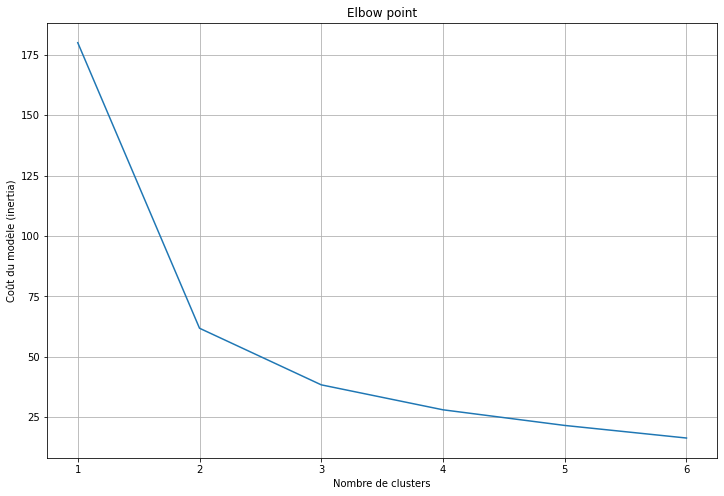

In [23]:
# Graphique
plt.figure(figsize=(12,8))
plt.grid()
plt.title("Elbow point")
plt.plot(k_range, inertia)
plt.xticks(k_range)
plt.xlabel("Nombre de clusters")
plt.ylabel("Coût du modèle (inertia)")
plt.show()

In [24]:
# elbow point
from kneed import KneeLocator

kl = KneeLocator(k_range, inertia, curve = "convex",direction = "decreasing")
elbowpoint = kl.elbow
print("elbow point : %.i" % (elbowpoint))

elbow point : 2


In [25]:
# Librairie pour évaluation des partition
from sklearn.metrics import silhouette_score

k_range = range(1,7)
silhouettecoef = []
for k in k_range:
    model = KMeans(n_clusters = k+1).fit(rowcoord)
    score = silhouette_score(rowcoord, model.labels_, random_state = 2022)
    silhouettecoef.append(score)

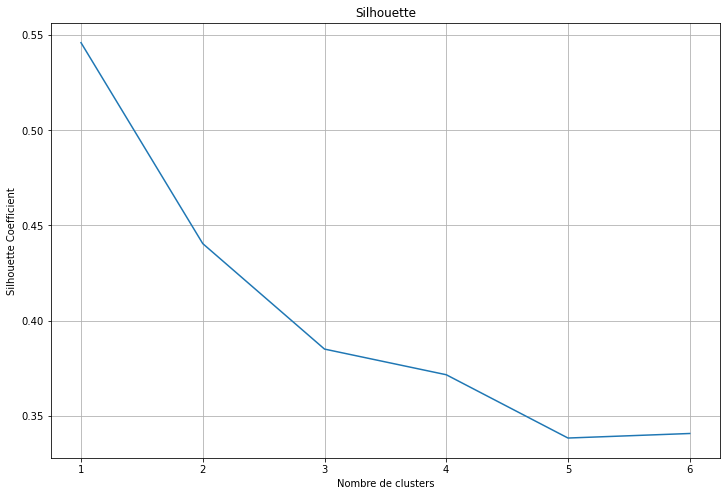

In [26]:
# Graphique
plt.figure(figsize=(12,8))
plt.grid()
plt.title("Silhouette")
plt.plot(k_range, silhouettecoef)
plt.xticks(k_range)
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()